In [7]:
from torch.xpu import device
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

device = 'mps'

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

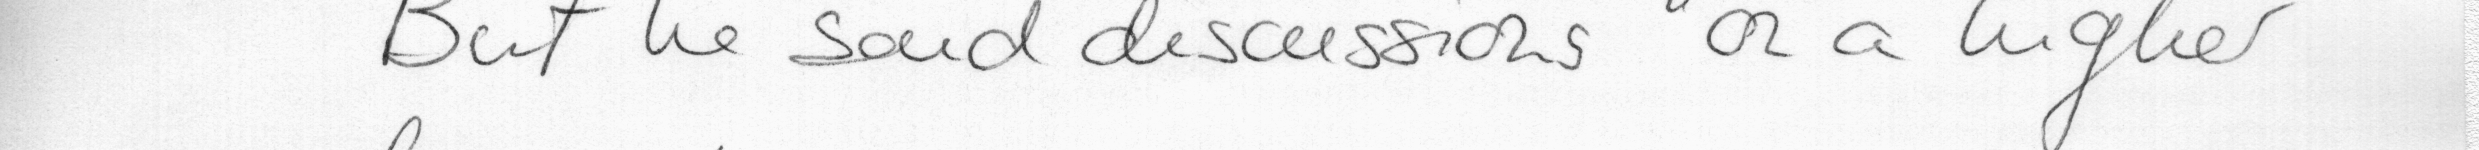

In [114]:
filepath = 'data/iam_form2.png'
image = Image.open(filepath).convert("RGB")

cropped_images = []
y = []
for i in range(700, image.height, 50):
    height  = 150
    cropped_image = image.crop((0, i, image.width, i + height))
    cropped_images.append(cropped_image)
    y.append(i)

cropped_images[4]

In [47]:
model.config.num_beams = 2

In [84]:
pixel_values = processor(images=cropped_images, return_tensors="pt").pixel_values.to(device)
output = model.generate(pixel_values, return_dict_in_generate=True, output_scores=True)
generated_ids, scores = output.sequences, output.sequences_scores
scores

/Users/amaljoe/Desktop/Workspace/IITB/NLP/OCR_with_LLMs/.venv/lib/python3.9/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([-0.6494, -0.7132, -0.2481, -0.0760, -0.0942, -1.0560, -0.2040, -0.0495,
        -0.2273, -0.4999, -0.3375, -0.0716, -0.7936, -0.0482, -0.0164, -0.4829,
        -0.5272, -0.1499, -0.0129, -0.7041, -0.5084, -0.0077, -0.0233, -1.2843,
        -0.2046, -0.1234, -0.2455, -0.5804, -0.1357, -0.0493, -1.8295, -0.4146,
        -0.1565, -0.3837, -0.5954, -0.0670, -0.1138, -0.8240, -1.5804, -1.7719,
        -1.6939, -0.7995, -0.5059, -0.5250, -1.2044, -2.7073, -1.8250, -0.6790,
        -0.4773, -1.2718, -1.0685, -1.0293, -0.5009, -0.4882, -0.4733, -0.9496,
        -1.0666], device='mps:0')

In [85]:
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
print(generated_texts)

['0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0', 'Download as PDFPrintable version', '# But he said discussions " on a higher', 'But he said discussions " on a higher', 'But he said discussions " on a higher', 'HelpLearn to remove the minimum manner .', 'level than in the past " might be " useful .', 'level than in the past " might be useful .', 'never than it the past might be useful .', 'The President , still probably discuss the', 'the President will probably discuss the', 'the President will probably discuss the', 'the musicians since pursuing business rule .', 'children with Dr. Brentano , the West', 'problem with Dr. Brentano , the West', 'problem with Dr. Svencove , the West', 'American Russian Minister of India is also a', 'German Foreign Minister , who is due in', 'German Foreign Minister , who is due in', 'women foreign ministers , who is due to', 'Washington next week . A basilico of', 'Washington next week . A big slice of', 'Washington next week . A big slice of', 'Not logged in'

In [56]:
import pandas as pd

scores_df = pd.DataFrame(scores.to('cpu'))

scores_df.describe()

,0
count,71.000000
mean,-0.762183
std,0.631554
min,-2.305190
25%,-1.216459
50%,-0.624377
75%,-0.150405
max,-0.008600


In [111]:
qualified_texts = []

for text, score, y_i in zip(generated_texts, scores.to('cpu').numpy(), y):
    if score > -0.15:
        print(f"Text: {text}, Score: {score}")
        qualified_texts.append({
            'text': text,
            'score': score,
            'y': y_i
        })

Text: But he said discussions " on a higher, Score: -0.07599374651908875
Text: But he said discussions " on a higher, Score: -0.09419003129005432
Text: level than in the past " might be useful ., Score: -0.049476757645606995
Text: the President will probably discuss the, Score: -0.0715705081820488
Text: children with Dr. Brentano , the West, Score: -0.048224084079265594
Text: problem with Dr. Brentano , the West, Score: -0.01644517108798027
Text: German Foreign Minister , who is due in, Score: -0.14991283416748047
Text: German Foreign Minister , who is due in, Score: -0.012892412021756172
Text: Washington next week . A big slice of, Score: -0.00771730812266469
Text: Washington next week . A big slice of, Score: -0.02325870469212532
Text: Germany's " aid " is the early payment ., Score: -0.12344066798686981
Text: of a 210million debt to America . United, Score: -0.13568785786628723
Text: of a 210million debt to America . United, Score: -0.049345239996910095
Text: this is money due to Am

In [112]:
from nltk.translate import bleu_score
from nltk.translate.bleu_score import SmoothingFunction

final_texts = []

def get_bleu_score(hypothesis, references):
    weights = [0.5, 0.5]
    smoothing = SmoothingFunction()
    return bleu_score.sentence_bleu(references, hypothesis, weights=weights, smoothing_function=smoothing.method1)

for i in range(len(qualified_texts)):
    hyp = qualified_texts[i]['text'].split()
    bleu = 0
    if i < len(qualified_texts) - 1:
        ref = qualified_texts[i + 1]['text'].split()
        bleu = get_bleu_score(hyp, [ref])
    qualified_texts[i]['bleu'] = bleu
    
qualified_texts_df = pd.DataFrame(qualified_texts)
qualified_texts_df

,text,score,y,bleu
0,"But he said discussions "" on a higher",-0.075994,850,1.000000
1,"But he said discussions "" on a higher",-0.094190,900,0.032910
2,"level than in the past "" might be useful .",-0.049477,1050,0.033333
3,the President will probably discuss the,-0.071571,1250,0.048872
4,"children with Dr. Brentano , the West",-0.048224,1350,0.845154
5,"problem with Dr. Brentano , the West",-0.016445,1400,0.042299
6,"German Foreign Minister , who is due in",-0.149913,1550,1.000000
7,"German Foreign Minister , who is due in",-0.012892,1600,0.000000
8,Washington next week . A big slice of,-0.007717,1750,1.000000
9,Washington next week . A big slice of,-0.023259,1800,0.037292


array([[<Axes: title={'center': '0'}>]], dtype=object)

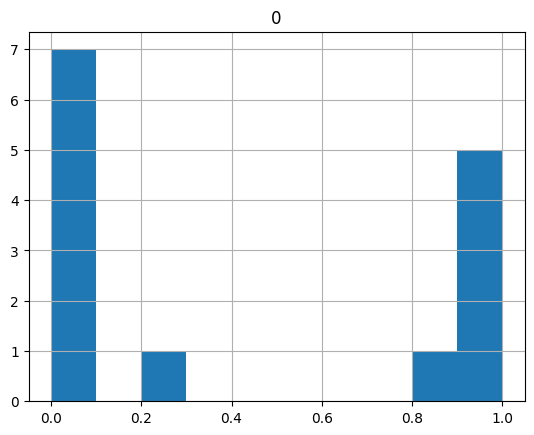

In [103]:
bleus_df = pd.DataFrame(bleus)

bleus_df.hist()

In [116]:
final_texts = []

new = True
for i in range(len(qualified_texts)):
    if new:
        final_texts.append(qualified_texts[i])
    else:
        if final_texts[-1]['score'] < qualified_texts[i]['score']:
            final_texts[-1] = qualified_texts[i]
    new = qualified_texts[i]['bleu'] < 0.5
    
final_texts_df = pd.DataFrame(final_texts)
final_texts_df

,text,score,y,bleu
0,"But he said discussions "" on a higher",-0.075994,850,1.000000
1,"level than in the past "" might be useful .",-0.049477,1050,0.033333
2,the President will probably discuss the,-0.071571,1250,0.048872
3,"problem with Dr. Brentano , the West",-0.016445,1400,0.042299
4,"German Foreign Minister , who is due in",-0.012892,1600,0.000000
5,Washington next week . A big slice of,-0.007717,1750,1.000000
6,"Germany's "" aid "" is the early payment .",-0.123441,1950,0.037268
7,of a 210million debt to America . United,-0.049345,2150,0.231455
8,this is money due to America anyway .,-0.066989,2450,1.000000
